# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import cv2

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


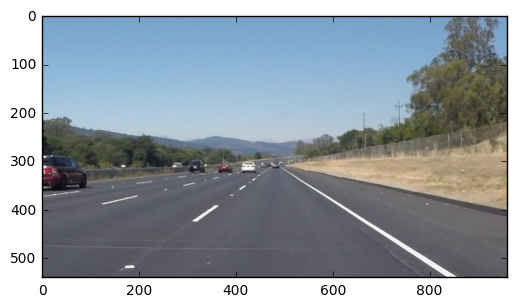

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def load_image(image_path):
    return mpimg.imread(image_path)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_noise(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = (255,)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    right_slope = []
    left_slope = []

    left_lines = []
    right_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1)) # slope
            if m < -.1:
                left_slope.append(m)
                left_lines.append((x2,y2))
            elif m > .1:
                right_slope.append(m)
                right_lines.append((x1,y1))
    
    right_slope = sorted(right_slope)[int(len(right_slope)/2)]
    left_slope = sorted(left_slope)[int(len(left_slope)/2)]

    left_y1 = sorted(left_lines, key=lambda x: x[1])[0][1]
    left_pair = sorted(left_lines, key=lambda x: x[1])[0]

    right_pair = sorted(right_lines, key=lambda x: x[1])[0]

    left_x = int((img.shape[1]-left_pair[1])/left_slope) + left_pair[0]
    right_x = int((img.shape[1]-right_pair[1])/right_slope) + right_pair[0]
    
    cv2.line(img, left_pair, (left_x, img.shape[1]), color, thickness)
    cv2.line(img, right_pair, (right_x, img.shape[1]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold,
                            np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

def get_files(dir_path):
    return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

def process_img(img):
    line_image = np.copy(img)
    gray_img = grayscale(img)
    blur_gray = gaussian_noise(gray_img, 5)
    edges = canny(blur_gray, 50, 150)

    imshape = img.shape
    vertices = np.array([[(105, .888*imshape[0]),
        (.333*imshape[1],
            .708*imshape[0]),
        (.528*imshape[1],
            .597*imshape[0]),
        (imshape[1], .805*imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)

    lines = hough_lines(masked_edges, 1, np.pi/180, 25, 10, 10)
#     final_img = weighted_img(lines, line_image)
#     
    zeros = np.zeros_like(lines)
    lines = np.dstack((lines, zeros, zeros))
    final_img = weighted_img(lines, line_image)
    return final_img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

processing solidWhiteCurve.jpg


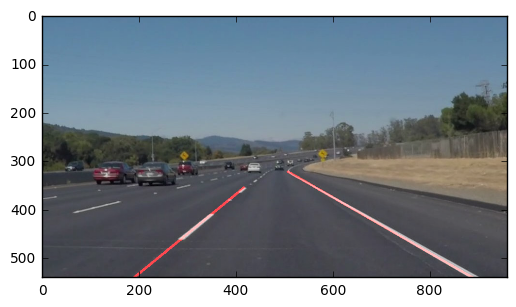

processing solidWhiteRight.jpg


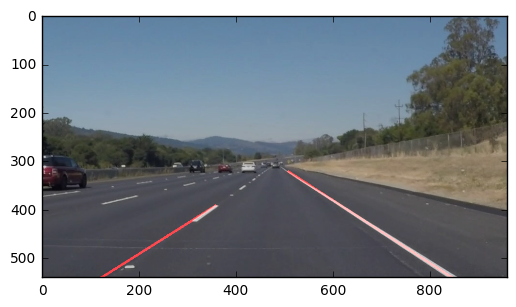

processing solidYellowCurve.jpg


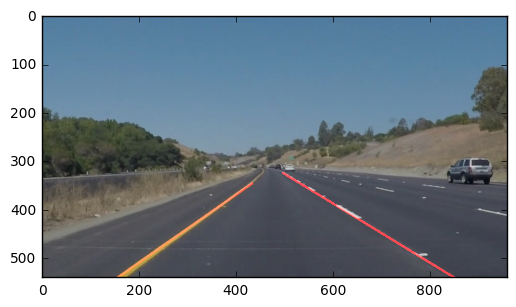

processing solidYellowCurve2.jpg


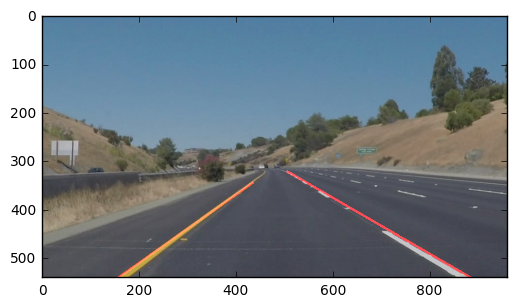

processing solidYellowLeft.jpg


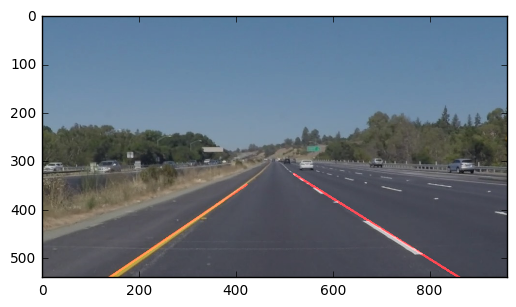

processing whiteCarLaneSwitch.jpg


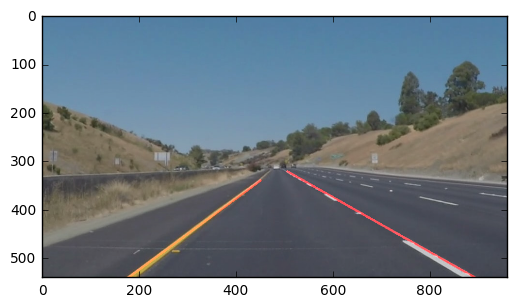

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

images = get_files('./test_images')

for name in images:

    if name.startswith("."): continue
        
    print("processing", name)
    
    img = load_image('{}/{}'.format('./test_images', name))
    
    img = process_img(img)
    
    plt.imshow(img)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_images(name, img):
    """
    # 1: grayscale the image
    # 2: define edges
    # 3: Hough transform
    # 4: Apply ROI
    """
    final_img = processs_img(img)


def process_video(name):
    """ ok """
    _output = 'final_'+name
    clip1 = VideoFileClip(name)
    white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
    white_clip.write_videofile(_output, audio=False)

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 76.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.25 s, sys: 555 ms, total: 2.81 s
Wall time: 3.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('./test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_img)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 71.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.23 s, sys: 1.59 s, total: 8.82 s
Wall time: 9.93 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Analysis

My solution is not very portable. It doesn't perform well on the challenge.  This is most likely due to the averaging of the slope which will not work well under a strong curve in the lane lines.

Rather than averaging the slope, __np.polyfit__ is probably a better approach especially for strongly curved lines.

Better tuning of the __HoughTransform__ parameters as well as the __Canny__ edge paramters could be improved, especially on the challenge video, so that things like the __shadow__ on the ground would not be detected.

I also do not maintain any history of previous frames, which if done can improve the detection.  This is covered in more detail in __P4__ Advanced Lane Detection.  

My opinion on this project is it was intended to familiarze students with the python programming language (who aren't already familiar with it) and introduce some of the challenges in Self-Driving cars.  I don't think it was intended to be used a robust solution for the task of lane detection.  This is further demonstrated in the __Computer Vision__ moduel and __P4__.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('./test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_img)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))